**Here, we are going to replicate the VolGAN-example file, by demonstrating the modifications we are making to the VolGAN file and introducing new functions we have created.**

In [77]:
#import libraries

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
import torch.nn as nn
warnings.filterwarnings("ignore")

#import files with supporting functions
import VolGANSwaps as VGS
import Inputs

#import our data sets and a sample date for testing
VOLATILITY_DATA = "data/swaption_atm_vol_full_NEW_no30y.xlsx"
FORWARDS_DATA = "data/forward_sofr_swap_full_NEW_no30y.xlsx"

**Data Loading**
- The data loader takes in the filepath to the volatility surface and the forward swap rates
- Constructs returns on underlying
- Processes the volatility data
    - The surface for every underlying asset is represented as a vector
    - This is similarly the case for the returns
- Sets up the tenor and tau matrices

In [78]:
surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(FORWARDS_DATA, VOLATILITY_DATA)

**Data Preprocessing**
- Within `DataPreprocessing` we call `SwapsData` like the original VolGAN implementation
- Here we construct the condition vector, construct the true labels and pass through some other data that might be relevant
    - Each underlying has a condition vector and the true labels (annualized return and log implied vol increment)
    - Because of this they will actually end up being tensor inputs to the models

In [79]:
# Data preprocessing example

true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(FORWARDS_DATA, VOLATILITY_DATA, vol_model='normal')
# true.shape
# condition.shape

**Data Train Test Split**
- Separates dataset into train and test datasets after processing and loading
- Parameterized by datasize percentage / proportion
- Parameterized by a data transformation assumption (`normal` or `log`)
    - Not directly related to volatility model assumptions 

In [80]:
true_train, true_test, condition_train,  condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(FORWARDS_DATA, VOLATILITY_DATA, 0.8, vol_model='normal')
# true_train.shape
# true_test.shape
# condition_train.shape
# condition_test.shape

**Next, we are going to run the model.**
- We updated the two training loops in the paper by ensuring the dimensionality of the computations were correct
- We also accounted for the fact that we are using the normal model
- If desired, we can still utilize 

In [81]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
n_epochs = 10000
n_grad = 25
val = True
vol_model = 'normal'
test_epoch = 100

This can be trained on either gpu or cpu.

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We present training for a low number of epochs to ensure that the loops work.
- Output of this volgan function provides us set of data used to train the models
- Also `gen` and `disc` are the trained models that we can then evaluate once trained for more epochs

In [83]:
gen, gen_opt, disc, disc_opt, true_train, true_val, true_test, condition_train, condition_val, condition_test, dates_t,  tenor, tau, tenors, taus  = VGS.VolGAN(FORWARDS_DATA,VOLATILITY_DATA, tr, noise_dim = noise_dim, hidden_dim = hidden_dim, n_epochs = test_epoch,n_grad = n_grad, lrg = 0.0001, lrd = 0.0001, batch_size = 100, device = device, vol_model=vol_model)

100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


alpha : 1.0103759921771957e-05 beta : 0.001662603939463326


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Visualize the results from the Gradient Matching

In [84]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
n_epochs = 10000
n_grad = 250
val = True
vol_model = 'normal'
lrg = 0.0001 
lrd = 0.0001 
batch_size = 100 

true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(FORWARDS_DATA, VOLATILITY_DATA, tr, vol_model, device)
gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lrg)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


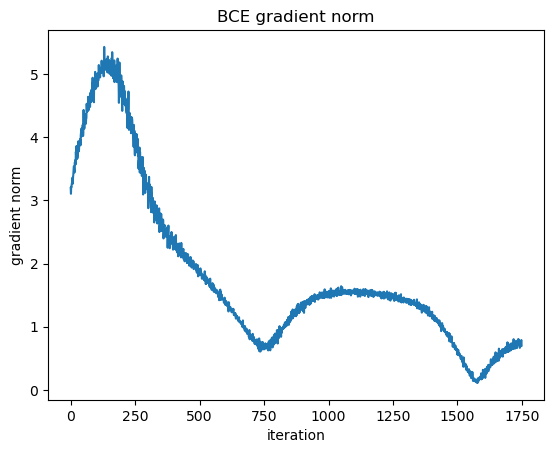

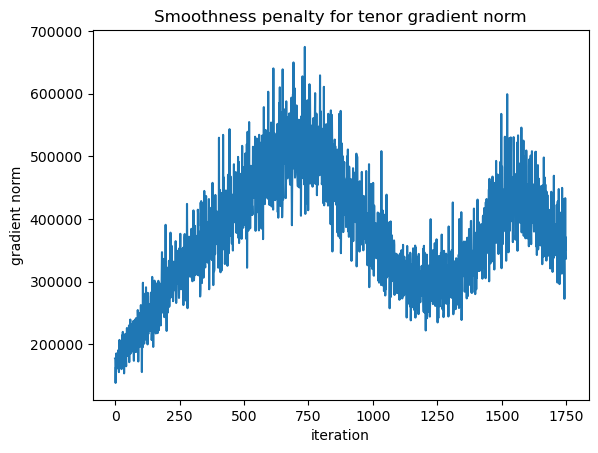

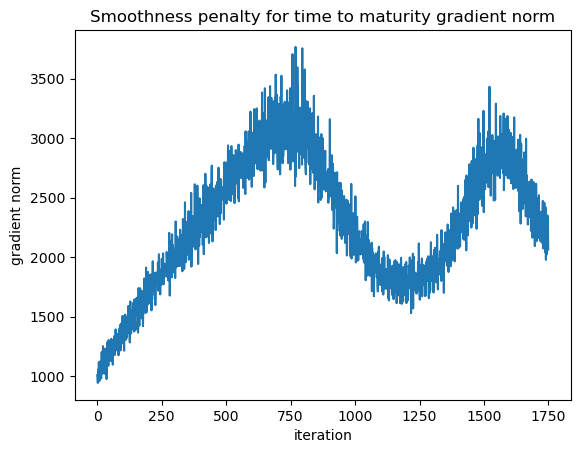

alpha : 5.957716026210835e-06 beta : 0.0009807208834572436


In [85]:
gen,gen_opt,disc,disc_opt,criterion, alpha, beta = VGS.GradientMatchingPlot(gen,gen_opt,disc,disc_opt,criterion,condition_train,true_train,tenor,tau,tenors,taus,n_grad,lrg,lrd,batch_size,noise_dim,device, vol_model=vol_model)

Full training with 10,000 epochs.

In [86]:
gen, gen_opt, disc, disc_opt, true_train, true_val, true_test, condition_train, condition_val, condition_test, dates_t,  tenor, tau, tenors, taus  = VGS.VolGAN(FORWARDS_DATA,VOLATILITY_DATA, tr, noise_dim = noise_dim, hidden_dim = hidden_dim, n_epochs = n_epochs,n_grad = n_grad, lrg = 0.0001, lrd = 0.0001, batch_size = 100, device = device, vol_model=vol_model)

100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


alpha : 5.603299108894575e-06 beta : 0.0009115327179608878


100%|██████████| 10000/10000 [50:54<00:00,  3.27it/s] 


**Saving and Loading Trained Model Parameters**

In [87]:
# exporting the model

gen_filepath = 'model/generator_parameters.pth'
disc_filepath = 'model/discriminator_parameters.pth'

torch.save(gen.state_dict(), gen_filepath)
torch.save(disc.state_dict(), disc_filepath)

In [88]:
# loading the model  

tr = 0.85
noise_dim = 32
hidden_dim = 16
n_epochs = 10000
n_grad = 250
val = True
vol_model = 'normal'
lrg = 0.0001 
lrd = 0.0001 
batch_size = 100 

gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)

gen.to(device)
disc.to(device)

Discriminator(
  (linear1): Linear(in_features=6, out_features=16, bias=True)
  (activation): Softplus(beta=1.0, threshold=20.0)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [89]:
gen.load_state_dict(torch.load(gen_filepath))
disc.load_state_dict(torch.load(disc_filepath))

<All keys matched successfully>

**Using the Generator**

Sample code for the following:
- Produce surfaces
- Produce returns

In [ ]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]
B = 10000

# collecting generated surfaces on test set from the generator

time_series_surfaces = []

print(f'Model: {vol_model}')

with torch.no_grad():
    for l in tqdm(range(B)):
        #sample noise
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise,condition_test[:,:,:])
        surface_past_test = condition_test[:,:,3:]

        #simulated implied vol surfaces as vectors
        if vol_model == 'normal':
            fake_surface = fake[:,:,1:] + surface_past_test
        elif vol_model == 'log':
            fake_surface = torch.exp(fake[:,:,1:] + surface_past_test)
        
        time_series_surfaces.append(fake_surface)

In [ ]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]

# collecting test returns from the generator

time_series_returns = []

with torch.no_grad():
    for l in tqdm(range(n_test)):
        #sample noise
        noise = torch.randn((1, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise, condition_test[l,:,:].unsqueeze(0))
        #simulated implied vol surfaces as vectors
        fake_returns = fake[:,:,:1].squeeze()

        time_series_returns.append(fake_returns)